In [1]:
import numpy as np
import cldnufuncs as cfunc
import matplotlib.pyplot as plt
import spherical_bin as sp
import window as win
import pkfuncs as pfunc
import sys

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
path = '/lfs/usrhome/phd/ph22d020/scratch/TGE_output/1000003840' # path to the Gridded visibilities.


Ncores = 4
Nmg = 20  # Number of realizations for Mg

# inputs
nc = 768

# nc is always used for total channels
NC = 1 # no. of channels to collapse
xn = 0 # no. of grids to exclude from from each sides of the gridded data.
na = nc//NC # No. of channels available after collapse.

# header
headersize = (nc+3)*np.float64().itemsize
hinfo = cfunc.read_header(str(path)+'/GV_data', headersize, nc)
hinfo = np.asarray(hinfo, dtype='object')
np.save(str(path)+'/hinfo', hinfo)

In [3]:
#hinfo

In [4]:
#eg    
#eg1 = cfunc.func_cldnu_multi(str(path)+'/GV_data_1000003720', nc, NC, xn, Ncores) 
#np.save(str(path)+'/eg-1000003720', eg1) # unnormalized estimate, can be normalized with Mg.

eg1 = np.load('/lfs/usrhome/phd/ph22d020/scratch/TGE_output/1000003840/eg.npy')
print('eg estimated. \n')



eg estimated. 



In [5]:
eg1.shape

(457, 457, 768)

In [6]:
#print(eg1[0,0,:])

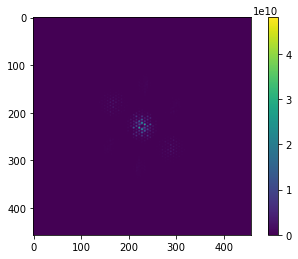

In [7]:
plt.imshow((eg1[:, :, 1]))
plt.colorbar()

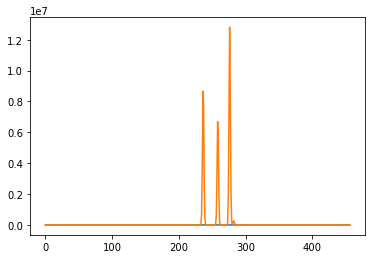

In [8]:
plt.plot(eg1[:,0,0])
plt.plot(eg1[0,:,0])

In [9]:
# Mg, save the GV-mg as GV-mg-1, GV-mg-2 etc. 

#mg = np.zeros_like(eg1)

#for ii in range(Nmg):
#    mg += cfunc.func_cldnu_multi(str(path)+'/GV-mg-'+str(ii+1), nc, NC, xn, Ncores)
#    print('Mg done for Re '+str(ii+1))
#mg /= Nmg
#np.save(str(path)+'/mg', mg) # unnormalized estimate, can be normalized with Mg.
#print('Mg estimated. \n')

In [10]:
# # 1. Noise in a grid: estimate noise in a grid for all realizations and save them
# Nnoise = 10 # Number of realizations for noise.
# for ii in range(Nnoise):
#     egn = cfunc.func_cldnu_multi(str(path)+'/GV-noise-'+str(ii+1), nc, NC, xn, Ncores)
#     np.save(str(path)+'/eg-noise/egn-'+str(ii+1), egn) # unnormalized estimate, can be normalized with Mg.
#     print('Noise done for Re '+str(ii+1)) # kept at a directory "eg-noise"

# print('Noise estimated in grids. \n')


# cl and PS calculations

In [11]:
FWHM, dUg, f, nua = np.load('/lfs/usrhome/phd/ph22d020/scratch/TGE_output/1000003840/hinfo.npy', allow_pickle=True)
eg = np.load('/lfs/usrhome/phd/ph22d020/scratch/TGE_output/1000003840/eg.npy')
mg = np.load('/lfs/usrhome/phd/ph22d020/scratch/TGE_output/1000003840/mg.npy') # mg = 800 Nrea. 

# eg to cl, binning parameters 
U1, U2, NBin = 0, 200, 10

# binning
el = cfunc.func_bincl(eg, dUg, U1, U2, NBin)
ml = cfunc.func_bincl(mg, dUg, U1, U2, NBin)
cl = el/ml # estimated cl (in a bin)


# # 2. Noise in a bin: read each realization from grid, bin them individually
# cln1 = np.zeros((Nrea, NBin, nc))
# for ii in range(Nnoise):
#     eln = np.load(str(path)+'/eg-noise/egn-'+str(ii+1)+'.npy')
#     cln1[ii] = cfunc.func_bincl(eln, dUg, U1, U2, NBin)/ml # normalized
# cln = np.std(cln1, axis=0)/np.sqrt(Nnoise)
cln = np.ones((NBin, nc)) # unit noise (when you have no noise estimates)

lb = cfunc.mk_lin_bin(mg, dUg, U1, U2, NBin)[0]*2.*np.pi # estimated ell (in a bin)
ell = np.intc(lb)
nell = len(ell)

clinfo = np.empty(3, dtype='object')
clinfo[:3] = cl, cln, lb
np.save(str(path)+'clinfo_.npy', clinfo) # all you need for PS

<ipython-input-11-03d82f289cf0>:11: RuntimeWarning: invalid value encountered in true_divide
  cl = el/ml # estimated cl (in a bin)


In [12]:
nell

10

In [13]:
cl.shape

(10, 768)

# PS

In [14]:
# read cl
cl_file, cln_file, lb = np.load('/lfs/usrhome/phd/ph22d020/scratch/TGE_output/1000003840/clinfo.npy', allow_pickle='True') # cl, cl-error, ell
FWHM, dUg, f, nua = np.load('/lfs/usrhome/phd/ph22d020/scratch/TGE_output/1000003840/hinfo.npy', allow_pickle=True)

#cl_file1, cln_file1, lb1 = np.load('/lfs/usrhome/phd/ph22d020/scratch/TGE/GV2PS/clinfo.npy', allow_pickle='True') # cl, cl-error, ell

In [15]:
cl = []
for i in range(cl_file.shape[0]):
    cl.append(cl_file[i][~np.isnan(cl_file[i])])
cl = np.array(cl)

In [16]:
cln = []
for i in range(cln_file.shape[0]):
    cln.append(cln_file[i][~np.isnan(cl_file[i])])
cln = np.array(cln)    

In [17]:
cln.shape

(10, 760)

In [18]:
# CL 

nc = cl.shape[-1]
nuc = nua.mean()/1e6 # nu_c
dnuc = abs(nua[1]-nua[0])/1e6 # delta-nu-c MHz
dnu = np.arange(nc)*dnuc # MHz
ell = np.intc(lb)
nell = len(ell)

# PS
r, rp = 9209.37, 16.98 # Mpc (Planck 2018) # z = 2.28 
#rp value should be fixed later

fac = r/(rp*nuc) # wedge boundary: kpara_H = fac*kper 
dkl = np.ones(nell)*1. # fixed buffer
# dkl[:] = np.array([0.5, 1.4, 1.0, 1.3, 0.02, 1., 1., 1., 1.2, 1.2]) #  # individual buffer for a kper-bin

vfac = rp*r*r*dnuc*(nc-1) # DCT factor 
kper = ell/r
kpara = 2.*np.pi*np.arange(nc)/(rp*(2.*nc-2.)*dnuc)
covi = 1/cln**2 # noise variance inverse 


# window for Fourier transform
w = win.window('BN', np.arange(nc))


In [19]:
lb.shape, ell

((10,),
 array([  73,  167,  327,  455,  558,  671,  803,  931, 1062, 1195],
       dtype=int32))

In [20]:
cl.shape

(10, 760)

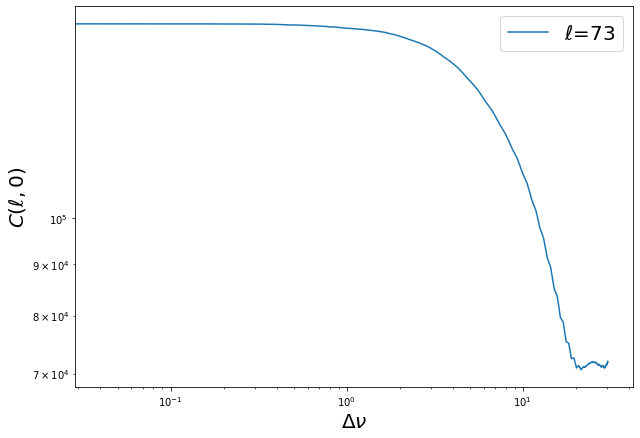

In [39]:
plt.figure(figsize = (10,7))
plt.plot(dnu,cl[0,:], label=r'$\ell$='+str(ell[0]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Delta \nu$',fontsize = '20')
plt.ylabel(r'$C(\ell ,0)$', fontsize = '20')
plt.legend(fontsize = 20)

No handles with labels found to put in legend.


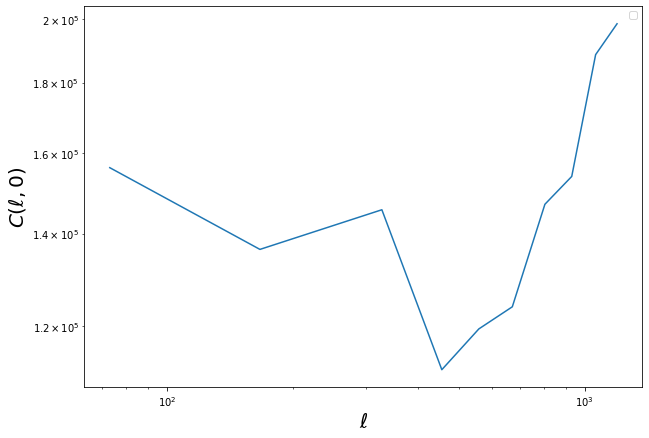

In [22]:
plt.figure(figsize = (10,7))
plt.plot(ell,cl[:,0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$',fontsize = '20')
plt.ylabel(r'$C(\ell ,0)$', fontsize = '20')
plt.legend()

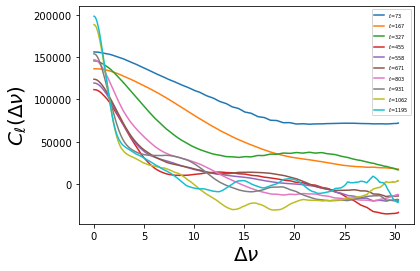

In [23]:
for ii in range(nell):
    #plt.figure(figsize = (10,7))
    plt.plot(dnu, cl[ii], label=r'$\ell$='+str(ell[ii]))
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel(r'$\Delta \nu$',fontsize = '20')
    plt.ylabel(r'$C_{\ell}(\Delta \nu)}$', fontsize = '20')
    plt.legend(fontsize = 5)

In [24]:
dnu.shape

(760,)

In [25]:
ell

array([  73,  167,  327,  455,  558,  671,  803,  931, 1062, 1195],
      dtype=int32)

In [26]:
cl.shape

(10, 760)

Text(0, 0.5, '$\\Delta \\nu$')

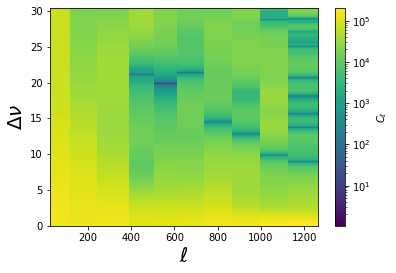

In [27]:
from matplotlib.colors import LogNorm
y, x = np.meshgrid(dnu, ell)
plt.pcolormesh(x, y, abs(cl), norm = LogNorm(), shading='auto') 
plt.colorbar(label = r'$C_{\ell}$')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel('$\ell$', fontsize = 20)
plt.ylabel(r'$\Delta \nu$',fontsize = '20')

Text(0, 0.5, '$\\Delta \\nu$')

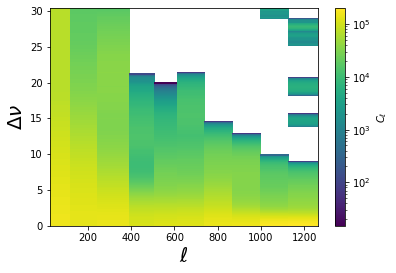

In [38]:
from matplotlib.colors import LogNorm
y, x = np.meshgrid(dnu, ell)
plt.pcolormesh(x, y, cl, norm = LogNorm(), shading='auto')
plt.colorbar(label = r'$C_{\ell}$')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel('$\ell$', fontsize = 20)
plt.ylabel(r'$\Delta \nu$',fontsize = '20')

In [28]:
#nc, nuc, dnuc, dnu, ell, nell
#covi

In [29]:
w.shape, cl.shape, covi.shape, vfac.shape

((760,), (10, 760), (10, 760), ())

In [30]:
pk = pfunc.func_pk(cl, w, covi, vfac) # MLE cylindrical PS P(kper, kpara) estimation

In [31]:
pk.shape

(10, 760)

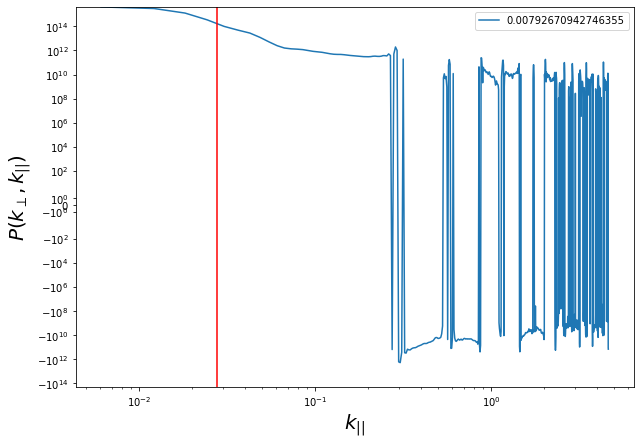

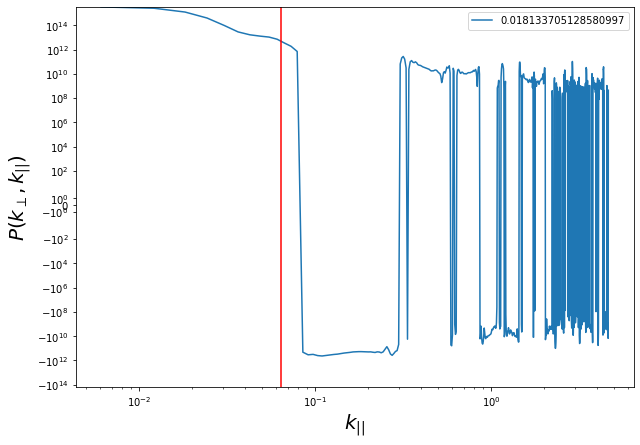

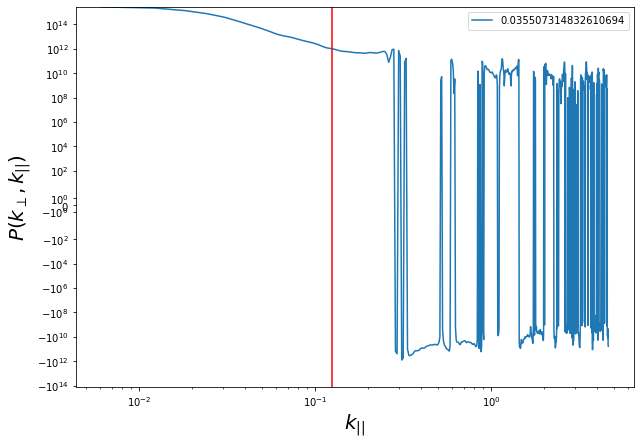

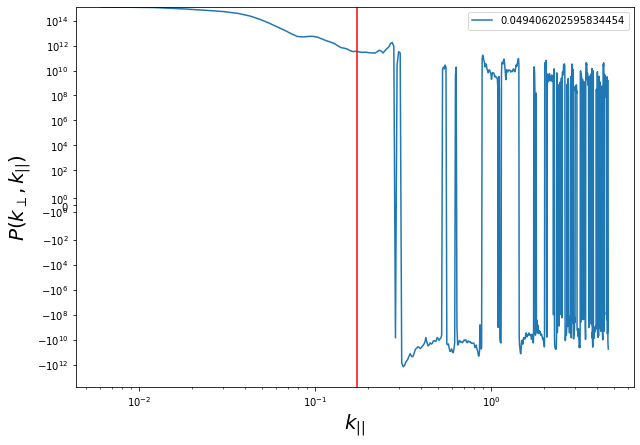

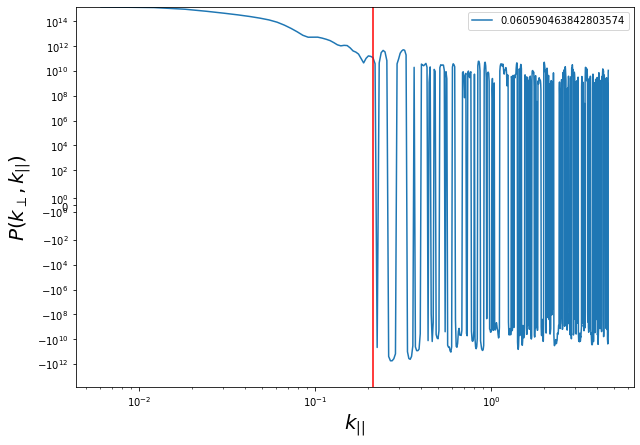

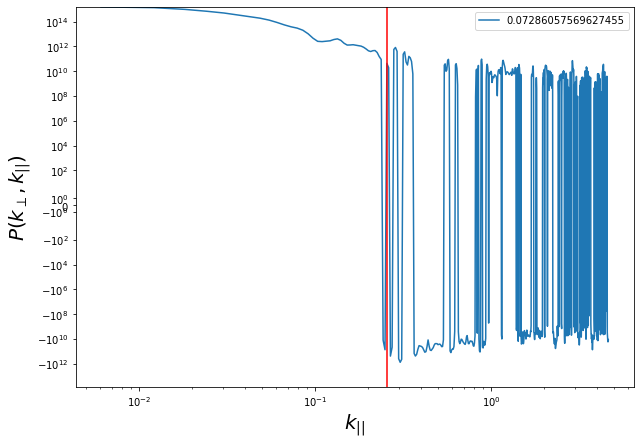

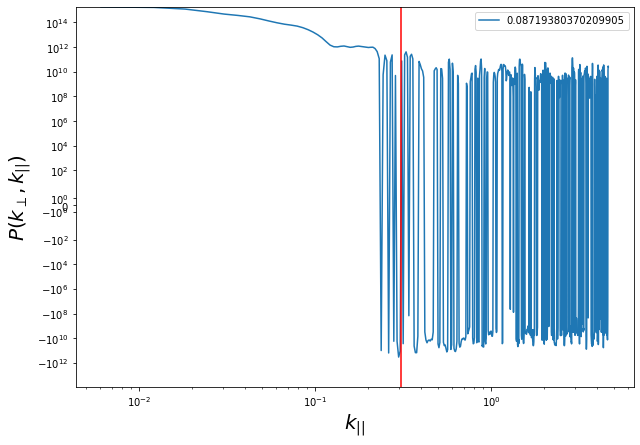

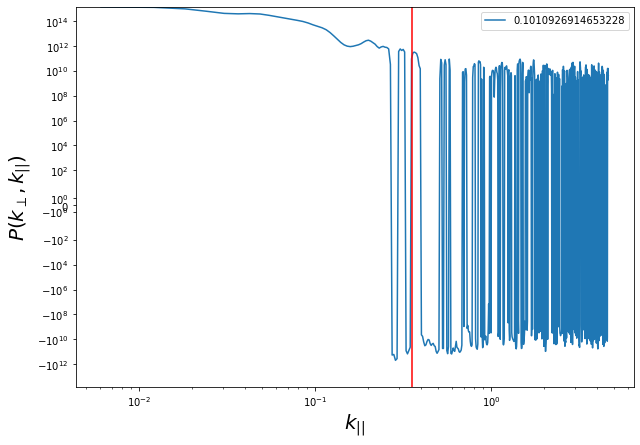

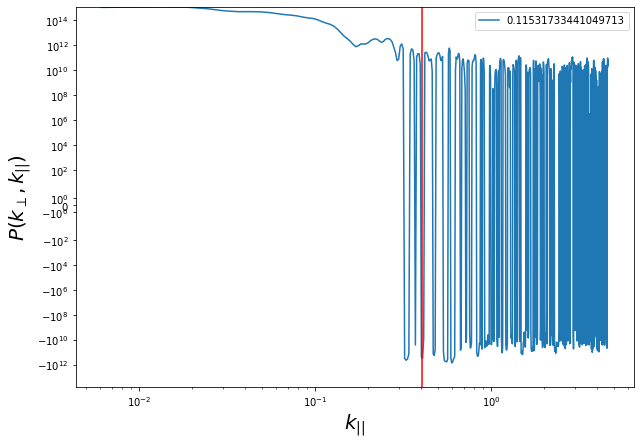

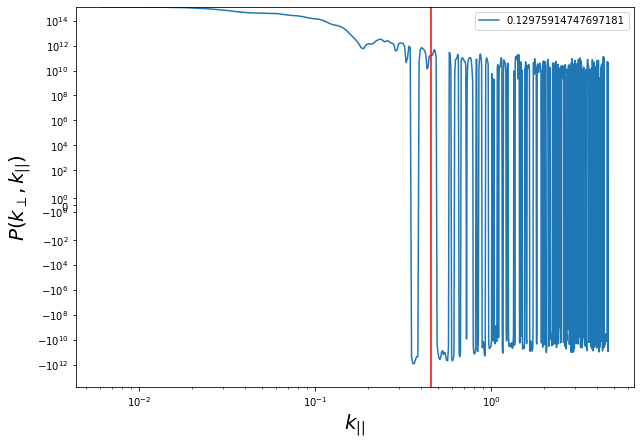

In [32]:
for ii in range(len(kper)):
    plt.figure(figsize = (10,7))
    plt.plot(kpara + kpara[1],pk[ii], label = str(kper[ii]))
    plt.xscale('log')
    plt.yscale('symlog')
    plt.axvline(x= fac*kper[ii], color = 'red')
    plt.xlabel(r'$k_{||}$',fontsize = '20')
    plt.ylabel(r'$P(k_{\perp}, k_{||})$', fontsize = '20')
    plt.legend(fontsize = 10)

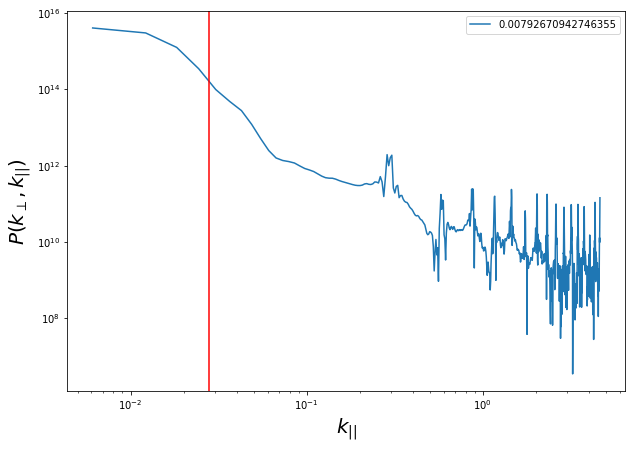

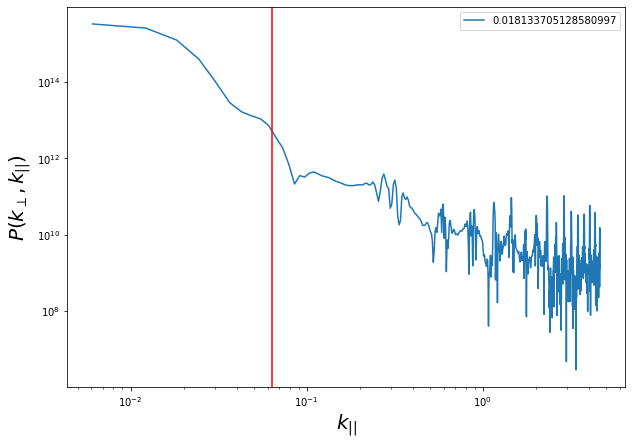

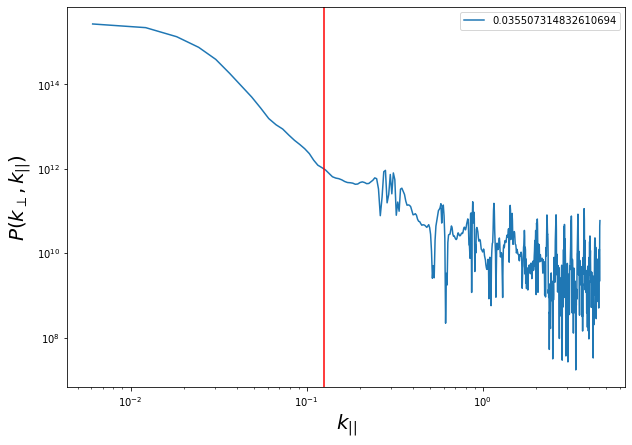

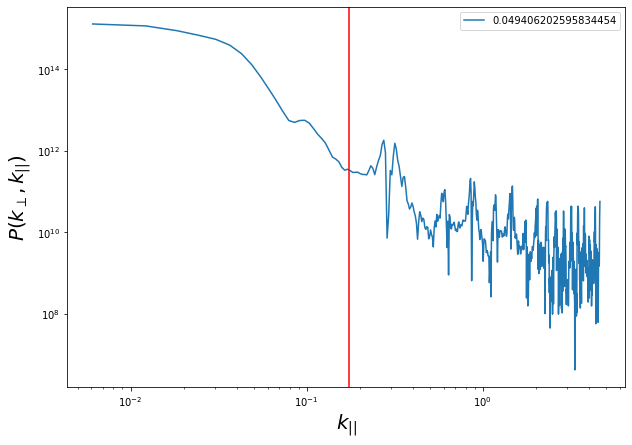

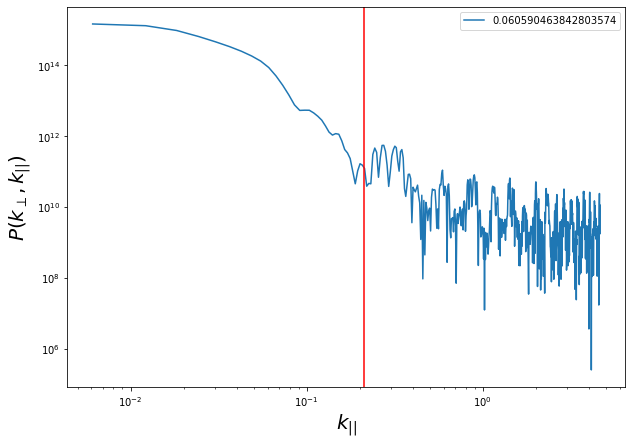

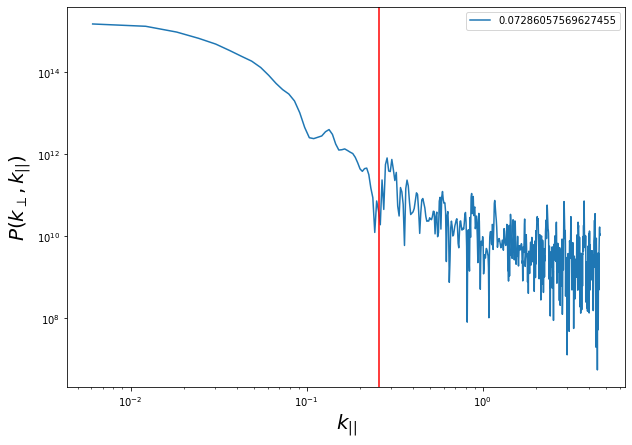

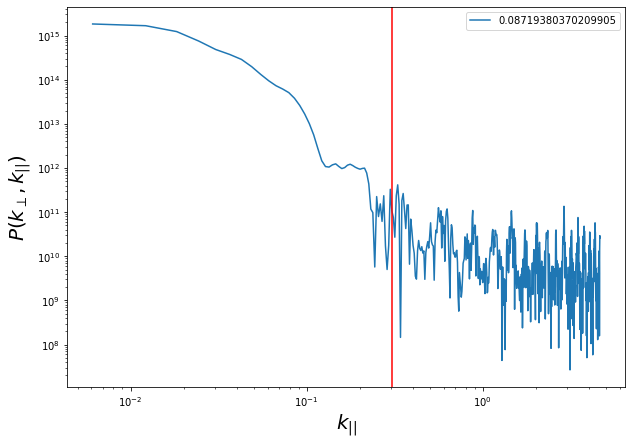

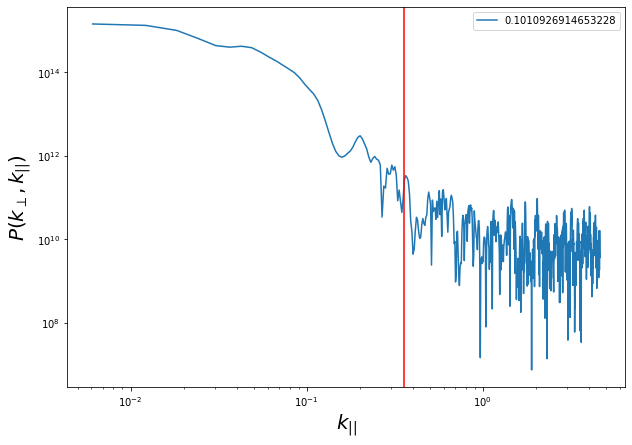

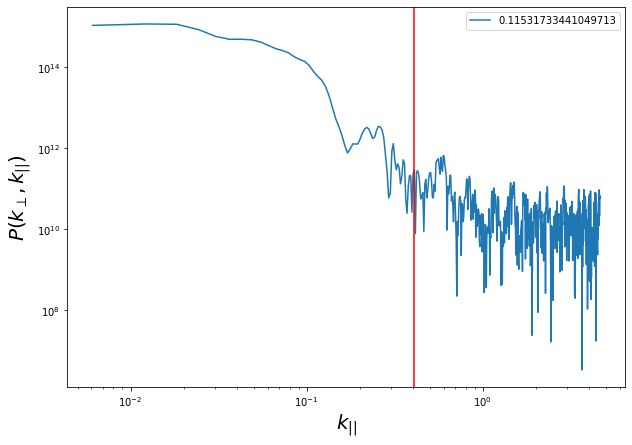

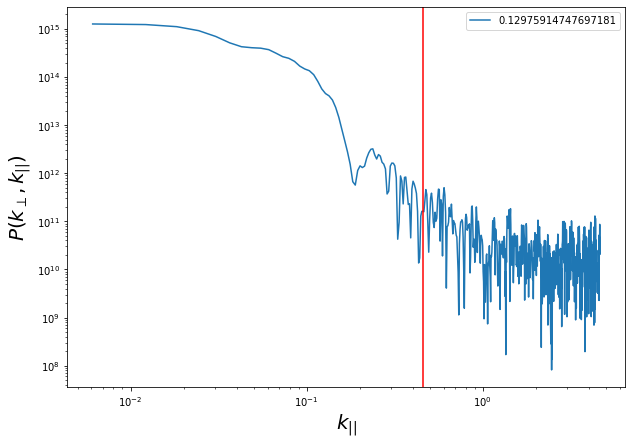

In [37]:
for ii in range(len(kper)):
    plt.figure(figsize = (10,7))
    plt.plot(kpara + kpara[1],abs(pk[ii]),label = str(kper[ii]))
    plt.xscale('log')
    plt.yscale('log')
    plt.axvline(x= fac*kper[ii], color = 'red')
    plt.xlabel(r'$k_{||}$',fontsize = '20')
    plt.ylabel(r'$P(k_{\perp}, k_{||})$', fontsize = '20')
    plt.legend()

Text(0, 0.5, '$k_{||}$')

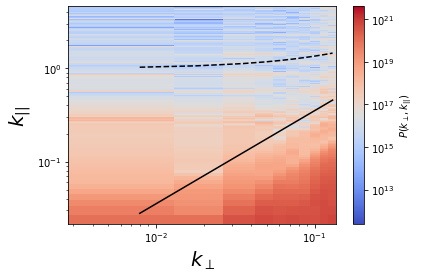

In [34]:
# A not-so-decent plot of cylindrical PS
from matplotlib.colors import LogNorm
y, x = np.meshgrid(kpara, kper)
plt.pcolormesh(x, y, abs(pk)*1e6, norm = LogNorm(), shading='auto', cmap='coolwarm')
plt.colorbar(label = r'$P(k_{\perp}, k_{||})$')

plt.xscale('log')
plt.yscale('log')
plt.plot(kper, fac*kper, 'k-')
plt.plot(kper, fac*kper + dkl, 'k--')
plt.xlabel(r'$k_{\perp}$', fontsize = 20)
plt.ylabel(r'$k_{||}$',fontsize = '20')

In [35]:
sys.exit()

SystemExit: 

/lfs/sware/anaconda3_2021/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Spherically averaged PS (Not MLE) 
NB = 6 # spherial bins
pks, kb, num = sp.binpk(pk,kper,kpara,dkl,fac,NB)

In [ ]:
# Spherical PS (MLE, Elahi et al. 2023 (under review))

AM, kk = sp.calc_AM(kper,kpara,dkl,fac,NB)

# covi = np.ones((nell, nc))
X, COV1 = sp.func_PE(AM, cl.flatten(), np.diag(covi.flatten()), NB, vfac) # p and COV
pp, COV = X[:NB], COV1[:NB, :NB]

# upper-limit
dTC1, ddTC1, ulC1 = sp.func_dT(kk, pp, COV) # 
kk,  np.sqrt(dTC1), np.sqrt(ddTC1), np.sqrt(ulC1), dTC1/ddTC1 # SNR
